__Before you turn the assignment in, make sure everything runs as expected__. First, *restart the kernel* (in the menubar, select Kernel$\rightarrow$Restart) and then *run all cells* (in the menubar, select Cell$\rightarrow$Run All). __Use the__ `Validate` __button in the Assignments tab before submitting__ to make sure that your assignment was filled in properly.

__Make sure you fill in any place that says__ `YOUR CODE HERE` or "YOUR ANSWER HERE". __Only one team member should upload the solutions.__

__Please fill in your names and S/U-numbers here:__
* Student 1 name, S/U-number: s1046670
* Student 2 name, S/U-number:
* Student 3 name, S/U-number:

---

# Statistical Machine Learning 2022
# Assignment 1
# Deadline: 6 October 2022
## Instructions
* You can __work in groups__ (= max 3 people). __Write the full name and S/U-number of all team members in the header above.__
* __Make sure you fill in any place that says__ `YOUR CODE HERE` or "YOUR ANSWER HERE" __including comments, derivations, explanations, graphs, etc.__ This means that the elements and/or intermediate steps required to derive the answer have to be in the report. (Answers like 'No' or 'x=27.2' by themselves are not sufficient, even when they are the result of running your code.) If an exercise requires coding, explain briefly what the code does (in comments). All figures should have titles (descriptions), axis labels, and legends (if applicable).
* Please do not add new cells to the notebook, try to write the answers only in the provided cells. __Before you turn the assignment in, make sure everything runs as expected__. First, *restart the kernel* (in the menubar, select Kernel$\rightarrow$Restart) and then *run all cells* (in the menubar, select Cell$\rightarrow$Run All). __Use the__ `Validate` __button in the Assignments tab before submitting__ to make sure that your assignment was filled in properly.
* The assignment includes certain cells that contain tests. Most of the tests are marked as *hidden* and are used for automatic grading. NB: These hidden tests do not provide any feedback! There are also a couple of tests / checks that are visible, which are meant to help you avoid basic coding errors.
* __For those working in groups, only one team member needs to upload the solutions__. This can be done under the Assignments tab, where you fetched the assignments, and where you can also validate your submissions. Please do not change the filenames of the individual Jupyter notebooks.
* For any problems or questions regarding the assignments, write on Discord or send an email to G.Bucur@cs.ru.nl .

## Introduction
Assignment 1 consists of:
1. __Polynomial curve fitting (50 points);__
2. Gradient descent (25 points);
3. Fruit boxes (25 points);
4. Probability factorization (BONUS 10 points);

## Libraries

First, we import the basic libraries necessary to develop this assignment. Of course you are free to import further libraries, if required, in the allotted cells. **Please avoid installing new packages, unless really necessary. Keep in mind that they will be installed in your "home-directory" folder, which has limited diskspace available.**

In [1]:
import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it to at least version 3."

# Necessary imports (for solutions)
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple

# Set fixed random seed for reproducibility
np.random.seed(2022)

## Polynomial curve fitting (weight 50)
Consider once more the $M$-th order polynomial 
$$
y(x;\mathbf{w}) = w_0 + w_1 x + \ldots + w_M x^M  = \sum_{j=0}^M w_j x^j \\
yxw \tag{1}
$$

### Exercise 1.1
Create the function $f(x) = 2 + \cos(6(x - 3))$. Generate a data set $\mathcal{D}_{10}$ of 10 noisy observations of this function. Take the 10 inputs spaced uniformly in range $[0,1]$, and assume that the noise is Gaussian with mean 0 and standard deviation 0.2. $\mathcal{D}_{10}$ will be the training set. In a similar way, generate an additional test set $\mathcal{T}$ of 100 noisy observations over the same interval. Plot both the function and observations in $\mathcal{D}_{10}$ in a single graph (similar to Bishop, Figure 1.2).

In [2]:
def f(x):
    """
    This function computes f(x) = 2 + cos(6(x−3))
    
    Parameters
    ----------
    x : float
        Input number.
    
    Returns
    -------
    float
        Result of the function.
    """
    # YOUR CODE HERE
    return 2 + np.cos(6*(x-3))

In [3]:
"""
Basic check that function f is correct.
"""
assert f(3) == 3.0
assert f(np.pi/2 + 3) == 1.0

In [115]:
"""
Generate a data set of N_train noisy observations of the function f. Take the inputs spaced uniformly
in range [0,1], and add Gaussian noise with mean 0 and standard deviation 0.2.

Variable names
--------------
N_train : int
    number of training observations
X_train : array
    N_train x 1 vector of x-coordinates, uniformly spaced between 0 and 1
t_train : array
    N_train x 1 vector with corresponding t-values, adding Gaussian noise
D_train : matrix
    N_train x 2 matrix, the training data created from X_train and t_train

N_test : int
    number of data points for testing
X_test : array
    N_test x 1 vector of random x-coordinates taken form a uniform distribution
t_test : array
    N_test x 1 vector with corresponding t-values, adding Gaussian noise
D_test : matrix
    N_test x 2 matrix, the test data created from X_test and t_test
"""
N_train = 10
X_train = np.linspace(0, 1, N_train)
t_train = [f(x) + np.random.normal(0, 0.2) for x in X_train]
D_train = np.dstack((X_train, t_train)).squeeze()

In [5]:
"""
Hidden test for variables N_train, X_train, t_train.
"""

'\nHidden test for variables N_train, X_train, t_train.\n'

### Exercise 1.2
Create a function `polynomial_curve_fit(D,M)` that takes as input a data set $\mathcal{D}_{N}$, consisting of $N$ input/output-pairs $\{x_n,t_n\}$, and a parameter $M$, representing the order of the polynomial in \eqref{yxw}, and outputs a vector of weights $$\mathbf{w} = [w_0, \dots, w_M]$$ that minimizes the sum-of-squares error function
$$ E(\mathbf{w}) = \frac{1}{2} \sum_{n=1}^N \{ y(x_{n} ; \mathbf{w}) - t_{n} \} ^2 \tag{2} $$
Hint: use the results from the Tutorial Exercises (Week 1, Exercise 5), and `np.linalg.solve` to solve a linear system of equations.

In [63]:
def polynomial_curve_fit(D, M):
    ''' This functions computes the value of a polynomial with weights w on data points x.
    
    Parameters
    ----------
    D : array
        Input dataset D.
    M : int
        The degree of the polynomial.
    
    Returns
    -------
    float
        Fitted weight vector w that minimizes the sum-of-squares function.
    '''
    A = np.zeros((M, M))
    T = np.zeros((M))
    
    for x_n, t_n in D:
        for i in range(0, A.shape[0]):
            T[i] += t_n*x_n**i
            for j in range(0, A.shape[1]):
                A[i,j] += x_n**(i+j)
        
    
    
    return np.linalg.solve(A, T)

polynomial_curve_fit(D_train, 3)


array([ 2.18225449, -4.55836623,  5.8909145 ])

In [33]:
"""
Hidden test for polynomial_curve_fit.
"""

'\nHidden test for polynomial_curve_fit.\n'

### Exercise 1.3
For the given dataset $\mathcal{D}_{10}$, run the `polynomial_curve_fit(D,M)` function for $M = [0, \dots, 9]$,  and, 
* Plot for various orders $M$ (at least for $M=0, M=1, M=3, M=9$) the resulting polynomial, together with the function $f$ and observations $\mathcal{D}_{10}$ (similar to Bishop, Fig 1.4)
* For each order $M \in [0, \dots, 9]$,  compute the root-mean-square error
$$\begin{equation*} E_{\text{RMS}} = \sqrt{2 E(\mathbf{w^*})/N} \tag{3} \end{equation*}$$
of the corresponding polynomial, evaluated on both the training set $\mathcal{D}_{10}$ and the testset $\mathcal{T}$.  Plot both as a function of $M$ in a single graph. (see Bishop, Figure 1.5).

First define the `polynomial` function to help you with calculating the predictions of outputs for the training and test data given w.

In [41]:
def polynomial(x, w):
    ''' This functions computes the value of a polynomial with weights w on data points x.
    
    Parameters
    ----------
    x : float
        Set of x-coordinates for which to evaluate the polynomial.
    w : float
        Input weight vector of size M+1 (for polynomial of degree M).
    
    Returns
    -------
    float
        Values of polynomial with weights w evaluated at x.
    '''
    # YOUR CODE HERE
    y = []
    for x_n in x:
        y_n = np.sum([w_j*x_n**j for j, w_j in enumerate(w)])
        y.append(y_n)   
    
    return np.array(y)

In [42]:
"""
Test for polynomial.
"""
assert np.array_equal(polynomial(np.array([1, 2]), np.array([1, 2, 3])),np.array([ 6., 17.]))

Now with the help of `polynomial` calculate the predictions. Then calculate the root-mean-square-error and 
create plots for various orders of $M$.

[ 2.89052408e+00 -2.76073424e+01  4.34793045e+02 -3.72892121e+03
  1.68636710e+04 -4.39037579e+04  6.84963242e+04 -6.31775952e+04
  3.17155007e+04 -6.67225845e+03]


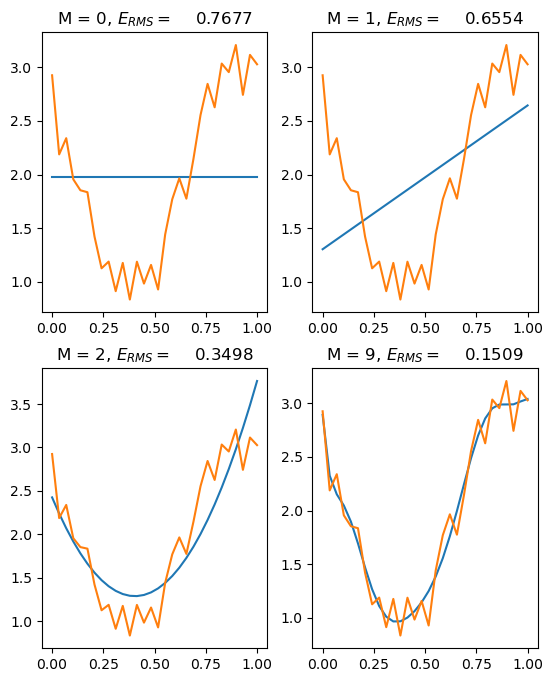

In [119]:
deg = [0, 1, 2, 9]
w0 = polynomial_curve_fit(D_train, deg[0]+1)
w1 = polynomial_curve_fit(D_train, deg[1]+1)
w3 = polynomial_curve_fit(D_train, deg[2]+1) 
w9 = polynomial_curve_fit(D_train, deg[3]+1)

y0 = polynomial(X_train, w0)
y1 = polynomial(X_train, w1)
y3 = polynomial(X_train, w3)
y9 = polynomial(X_train, w9)

y = [y0, y1, y3, y9]

def plot(y, t):
    fig, axs = plt.subplots(2, 2)
    fig.set_figheight(8)
    for i, (y_n, ax) in enumerate(zip(y, axs.ravel())):
        E = 0.5 * np.sum((y_n - t)**2)
        E_rms = np.sqrt(2*E/len(t))
        ax.set_title("M = %s, $E_{RMS}=$%s" % (deg[i], f"{E_rms:10.4f}"))
        ax.plot(X_train, y_n)
        ax.plot(X_train, t)


plot(y, t_train)


### Exercise 1.4
Repeat this procedure for a data set $\mathcal{D}_{30}$ of 30 observations (with the same noise level) and compare with the previous result.

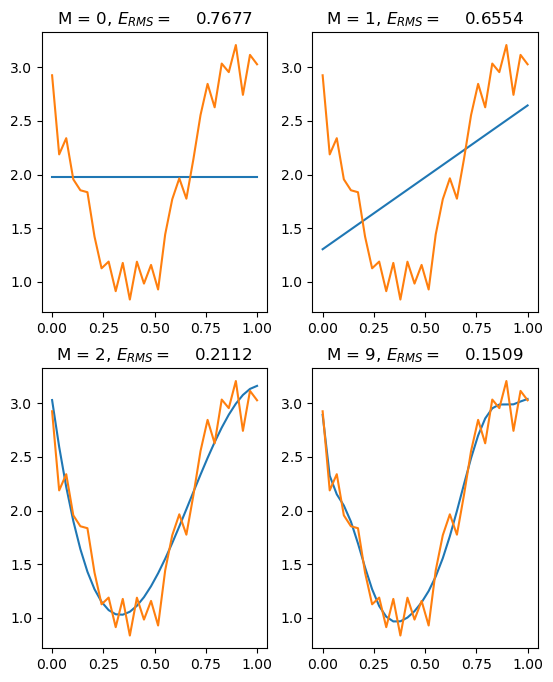

In [117]:
# YOUR CODE HERE
N_train = 30
X_train = np.linspace(0, 1, N_train)
t_train = [f(x) + np.random.normal(0, 0.2) for x in X_train]
D_train = np.dstack((X_train, t_train)).squeeze()

w0 = polynomial_curve_fit(D_train, 1)
w1 = polynomial_curve_fit(D_train, 2)
w3 = polynomial_curve_fit(D_train, 4) 
w9 = polynomial_curve_fit(D_train, 10)

y0 = polynomial(X_train, w0)
y1 = polynomial(X_train, w1)
y3 = polynomial(X_train, w3)
y9 = polynomial(X_train, w9)

y = [y0, y1, y3, y9]

plot(y, t_train)

For $M=9$ where $\mathcal{D}_{10}$ the $E_{RMS}$ was is exactly 0, meaning the polynomial fit exactly to the data. The $\mathcal{D}_{30}$ $E_{RMS}$ is higher, but the model didn't over overfit and thus works with more data.  
$M=3$ seems to work the best for $\mathcal{D}_{30}$, it is most similar to a cosinusidal wave which was the original data generating process.

### Exercise 1.5
Modify the `polynomial_curve_fit(D,M)` function to include an additional penalty parameter $\lambda$, for a procedure that solves the minimization problem for a modified error function with quadratic regularizer (weight decay), given as
$$
\tilde{E} = E + \frac{\lambda}{2} \sum_{j=0}^M w_j^2. \tag{4}
$$
Verify that the regularizer drives the weights of high order terms in the polynomial to zero, and see if you can reproduce and explain the effect observed in Bishop, Figure 1.8.

In [120]:
def polynomial_curve_fit(D, M, lmb = 0):
    ''' This functions computes the value of a polynomial with weights w on data points x.
    
    Parameters
    ----------
    D : array
        Input dataset D.
    M : int
        The degree of the polynomial.
    
    Returns
    -------
    float
        Fitted weight vector w that minimizes the sum-of-squares function.
    '''
    A = np.zeros((M, M))
    T = np.zeros((M))
    
    for x_n, t_n in D:
        for i in range(0, A.shape[0]):
            T[i] += t_n*x_n**i
            for j in range(0, A.shape[1]):
                A[i,j] += x_n**(i+j)
                if (i == j):
                    A[i,j] += lmb
        
    
    
    return np.linalg.solve(A, T)

In [121]:
"""
Hidden test for polynomial_curve_fit.
"""

'\nHidden test for polynomial_curve_fit.\n'

YOUR ANSWER HERE

### Exercise 1.6
The polynomial curve fitting procedure can be extended to the case of multidimensional inputs. Assuming an input vector  of dimension $D$, namely $\mathbf{x} = (x_1, x_2, \dots, x_D)$, we can write the regression function $y$ as:
\begin{equation}
y(\mathbf{x}; \mathbf{w}) = \sum_{j = 0}^M \left( \sum_{n_1 + n_2 + ... + n_D = j} w_{n_1 n_2 ... n_D} x_1^{n_1} x_2^{n_2} ... x_D^{n_D} \right) \label{eqn:polynomial_multidimensional} \tag{5}
\end{equation}

In the last expression, $j$ refers to the order of the polynomial terms. The inner sum is over all the combinations of non-negative integers $n_1, n_2, \dots, n_D$, such that the constraint $n_1 + n_2 + \dots + n_D = j$ holds. The terms $n_1, n_2, \dots, n_D$ correspond to the exponent for each variable $x_1, x_2, \dots, x_D$ in their respective polynomial term.

Note that if $D = 1$, the above expression simplifies to the formula in equation \eqref{yxw}. The reason the second sum disappears is that there is only one combination of the non-negative integer $n_1$ for which the constraint $n_1 = j$ holds, which means that there is only  a single term to sum over.

Fitting the polynomial curve to a multidimensional input vector works analogously to the one-dimensional case. However, the number of parameters (the size of $\mathbf{w}$) becomes much larger, even when $D = 2$. Write down the general polynomial curve equation in \eqref{eqn:polynomial_multidimensional} for $D = 2$. How many parameters are needed in the two-dimensional case? Compare this to the number of parameters in the one-dimensional case.

YOUR ANSWER HERE